# COMP1844 Information Analysis and Visualisation
## Vũ Trần Quang Minh - 001325733 - COS1104
### Task 1: Develop a Python program which generates the image of the map:

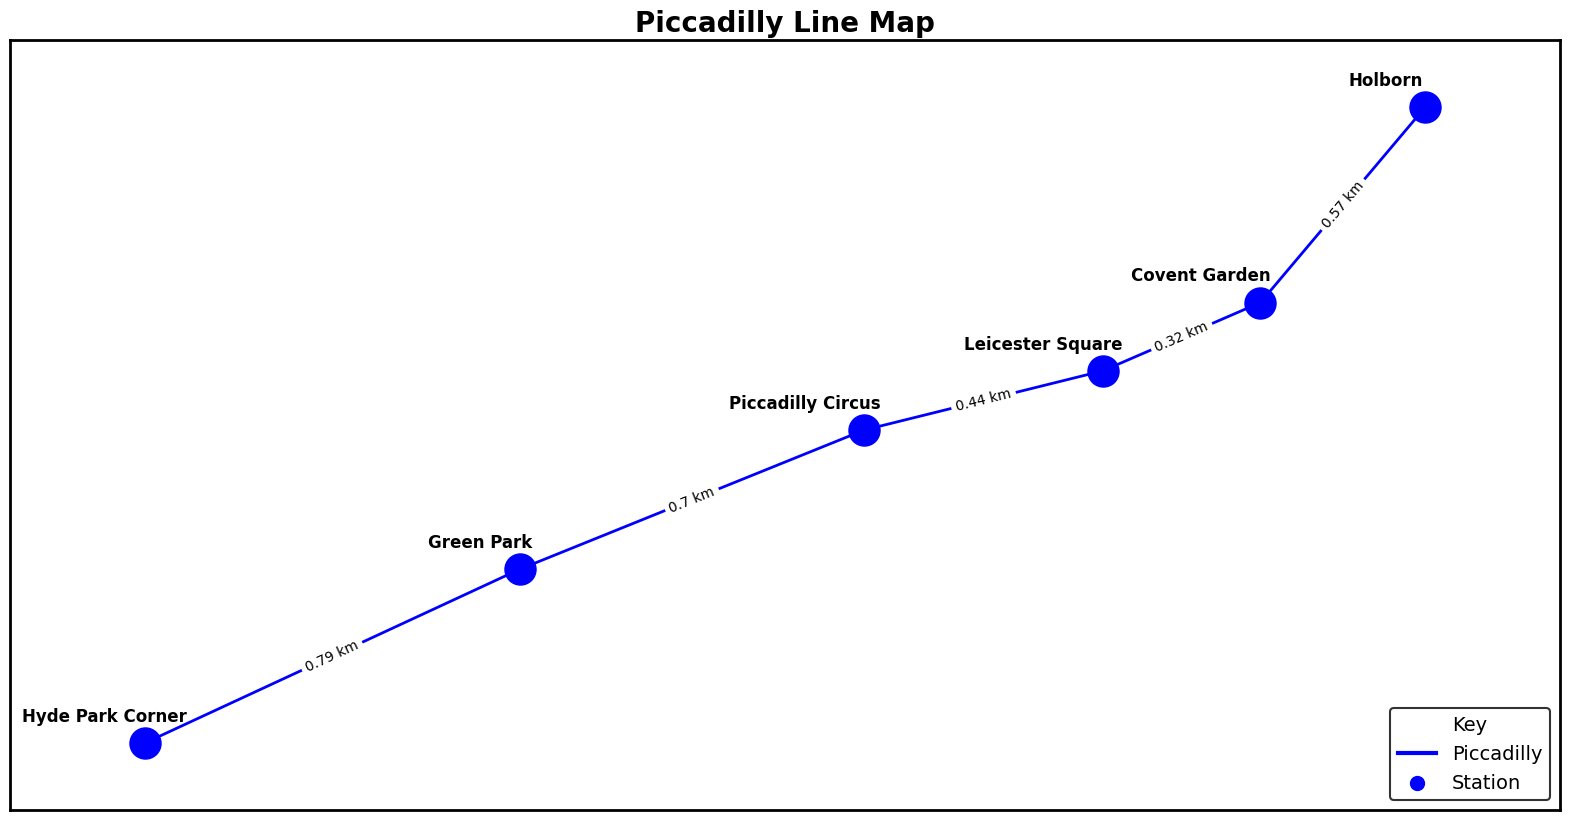

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ------------------- Data Loading -------------------
# Load the CSV file and strip spaces from column names
file_path = 'London stations.csv'  # Update this to your file path
stations_data = pd.read_csv(file_path)
stations_data.columns = stations_data.columns.str.strip()  # Remove extra spaces

# ------------------- Haversine Function -------------------
# Define the haversine distance function to calculate the distance between two geographic points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# ------------------- Graph Data Preparation -------------------
# Define edges between stations
edges = [
    ("Hyde Park Corner", "Green Park"),
    ("Green Park", "Piccadilly Circus"),
    ("Piccadilly Circus", "Leicester Square"),
    ("Leicester Square", "Covent Garden"),
    ("Covent Garden", "Holborn"),
]

# Calculate distances and assign to edges
colored_edges = []
for edge in edges:
    station1 = stations_data[stations_data['Station'] == edge[0]].iloc[0]
    station2 = stations_data[stations_data['Station'] == edge[1]].iloc[0]
    distance = haversine(station1['Latitude'], station1['Longitude'],
                         station2['Latitude'], station2['Longitude'])
    colored_edges.append((edge[0], edge[1], round(distance, 2), 'blue'))

# ------------------- Graph Creation -------------------
# Create the graph and add nodes with positions
G = nx.Graph()
for _, row in stations_data.iterrows():
    G.add_node(row['Station'], pos=(row['Longitude'], row['Latitude']))

# Add edges with distances
G.add_edges_from([(edge[0], edge[1]) for edge in colored_edges])

# ------------------- Visualization Settings -------------------
# Define edge colors and edge labels
edge_colors = ['blue'] * len(G.edges)
edge_labels = {edge[:2]: f"{edge[2]} km" for edge in colored_edges}

# Define adjusted label positions for nodes
label_pos_adjustments = {
    "Hyde Park Corner": (-0.001, 0.0006),
    "Green Park": (-0.001, 0.0006),
    "Piccadilly Circus": (-0.0015, 0.0006),
    "Leicester Square": (-0.0015, 0.0006),
    "Covent Garden": (-0.0015, 0.0006),
    "Holborn": (-0.001, 0.0006),
}

# Adjust label positions for plotting
adjusted_positions = {
    station: (coords[0] + label_pos_adjustments.get(station, (0, 0))[0],
              coords[1] + label_pos_adjustments.get(station, (0, 0))[1])
    for station, coords in nx.get_node_attributes(G, 'pos').items()
}

# ------------------- Graph Visualization -------------------
plt.figure(figsize=(20, 10))
ax = plt.gca()

# Remove grid and add a black border box
ax.grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Draw nodes (stations)
nx.draw_networkx_nodes(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    node_size=500,
    node_color='blue'
)

# Draw edges (connections)
nx.draw_networkx_edges(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    edge_color=edge_colors,
    width=2
)

# Draw station labels with adjusted positions (in black)
nx.draw_networkx_labels(
    G,
    pos=adjusted_positions,
    font_size=12,
    font_weight='bold',
    font_color='black'
)

# Draw edge labels with distances in "km" (in black)
nx.draw_networkx_edge_labels(
    G,
    pos=nx.get_node_attributes(G, 'pos'),
    edge_labels=edge_labels,
    font_color='black'
)

# ------------------- Add Legend and Final Adjustments -------------------
# Manually create a legend with a line and a circle, without bold text
plt.plot([], [], color='blue', linewidth=3, label='Piccadilly')  # Line for the Piccadilly line
plt.scatter([], [], color='blue', s=100, label='Station')  # Circle for the stations

legend = plt.legend(
    loc='lower right',
    title='Key',
    frameon=True,
    fontsize=14,
    title_fontsize=14  # No bold text for legend
)

# Add a border to the legend
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1.5)

# Add title and show the plot
plt.title("Piccadilly Line Map", fontsize=20, fontweight='bold')
plt.show()
